In [25]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
import os.path
from utils import *
from run_simulations import *
from agents import *

%matplotlib notebook
%reload_ext autoreload
%autoreload 2


import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

In [31]:
# world = ForagingWorld(prew=0.9, psw=0.1, pstruct=[5, 100], nblockmax=1000)
rlow = 0
rhigh = 1
ntrials_per_block = [10, 40]
nblocks = 1000
world, ntrials = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = ValueAccumulationAgent(gamma=0.5, beta=20)
# agent = EGreedyQLearningAgent(gamma=1.3, eps=0.1)
exp = Experiment(agent, world)
exp.run()  

choicelst = split_by_trials(agent.choice_history, world.ntrialblocks, chop='none')
arr = choicelst[0]
#get_num_rewards_trailing_block(world, agent)
z_states = get_zstates(agent)


pr, pl, choicelst = find_LR_transition_fit(world, agent, window=30)

In [32]:
pl

array([ 9.90447596e-01, -5.00440913e+00,  5.45473165e-04])

In [33]:
pr

array([-1.03544534e+00, -5.02929637e+00,  3.44172942e-04])

<IPython.core.display.Javascript object>


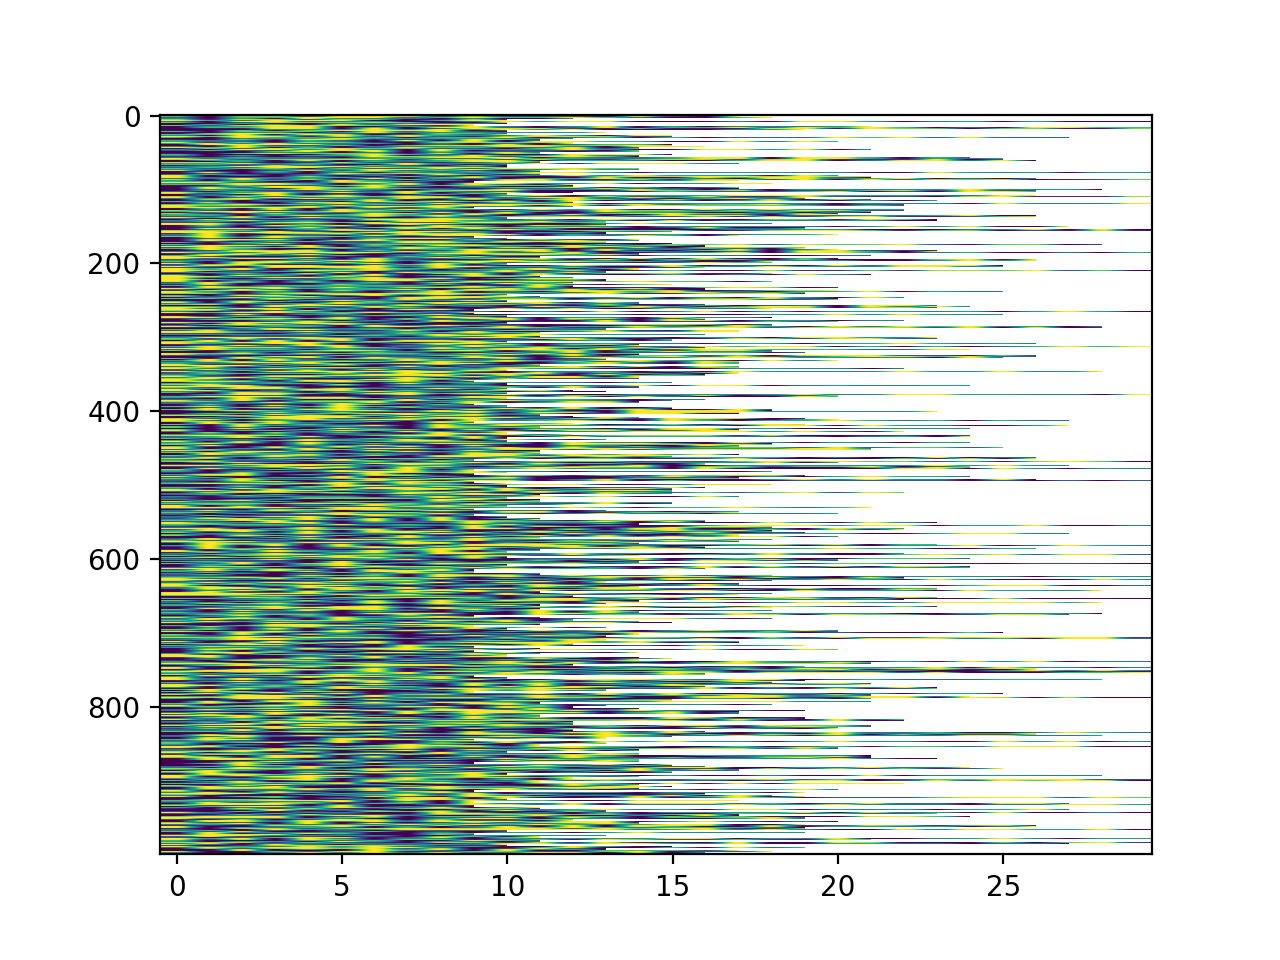

In [8]:
plt.figure()
plt.imshow(choicelst, aspect='auto')

In [22]:
fit_sigmoidal(choicelst, first_side=True)

(array([-0.00322502, -2.99999982,  0.        ]),
 array([ 2.71214802e-03, -9.99999889e-01,  2.49976189e-09]))

<IPython.core.display.Javascript object>


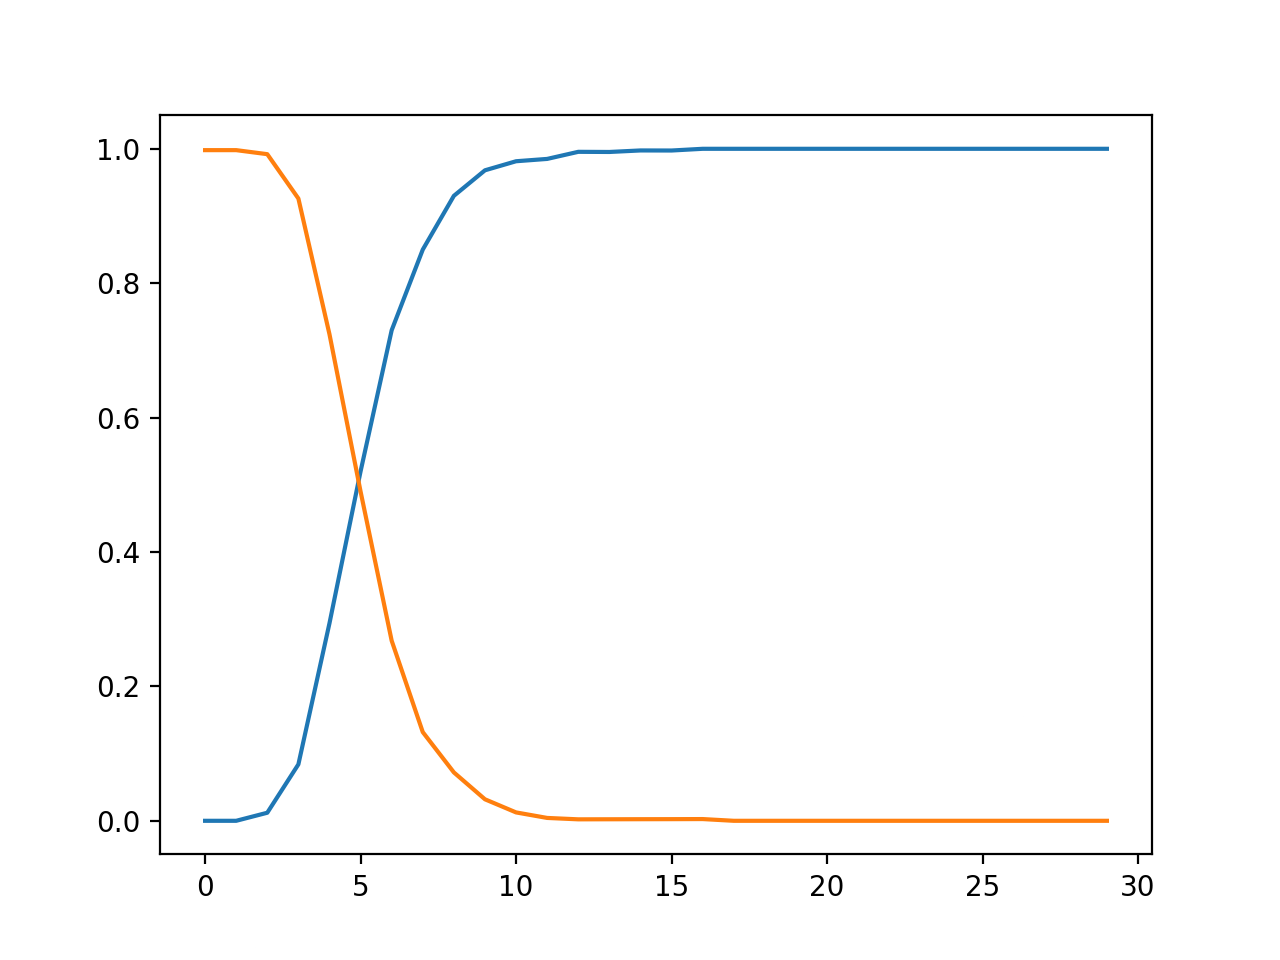

In [34]:
plt.figure()
rightAverage = np.nanmean(choicelst[1::2, :], axis=0)
leftAverage = np.nanmean(choicelst[::2, :], axis=0)
plt.plot(leftAverage)
plt.plot(rightAverage)

In [21]:
offsetsR = np.arange(len(rightAverage))
offsetsL = np.arange(len(leftAverage))

# Fit right transitions
# print(rightAverage)
funR = lambda x: errorsigmoid(x, offsetsR, rightAverage)
switchGuessR = find_transition_guess_binary(rightAverage)  # offset that crosses 0.5
if switchGuessR == -1:  # No switch happened!
    # pRight = [0, -np.inf, 0]
    paramsRight = scipy.optimize.minimize(funR, [1, -len(rightAverage), 0],
                                          bounds=((None, 0), (None, 0), (0, 0.5)))
else:
    paramsRight = scipy.optimize.minimize(funR, [1, -switchGuessR, 0],
                                          bounds=((None, 0), (None, 0), (0, 0.5)))
pRight = paramsRight.x

In [30]:
pRight

array([-0.00322502, -2.99999982,  0.        ])

<IPython.core.display.Javascript object>


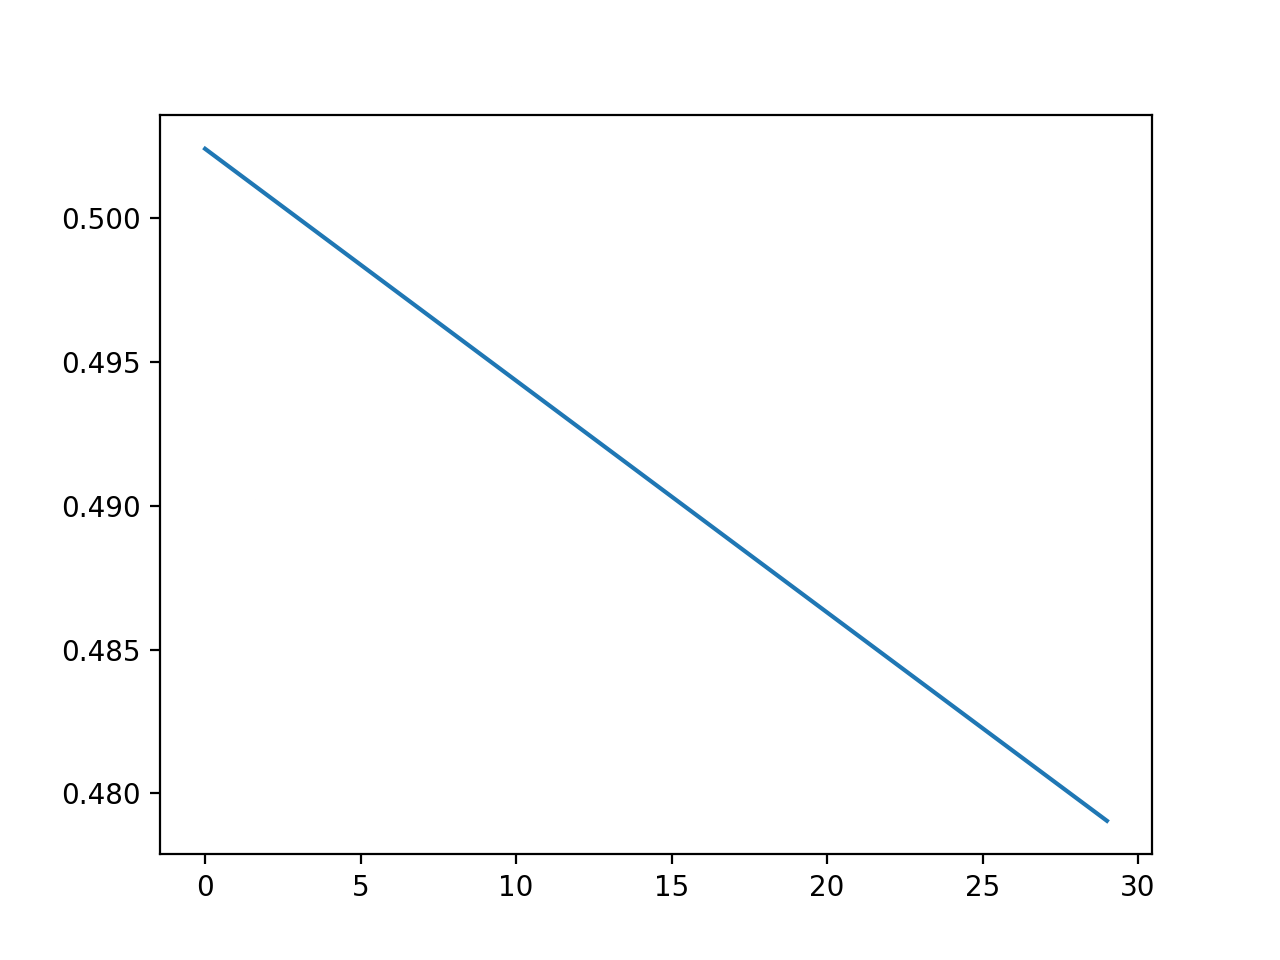

In [29]:
preds = predict_sigmoid(pRight, offsetsR)
plt.plot(offsetsR, preds)

In [27]:
offsetsR

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

<IPython.core.display.Javascript object>


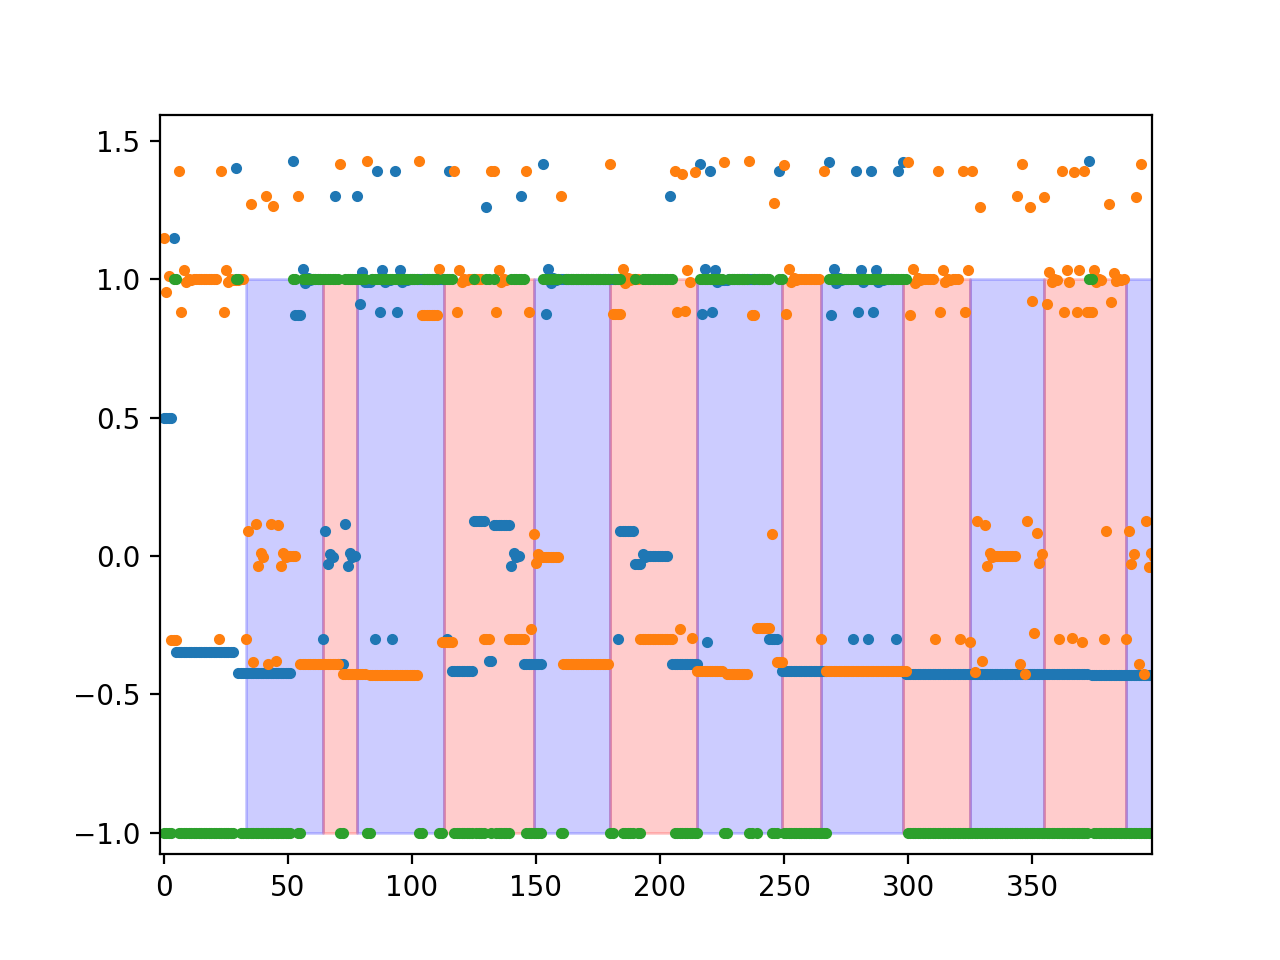

In [96]:
exp.visualize()


<IPython.core.display.Javascript object>


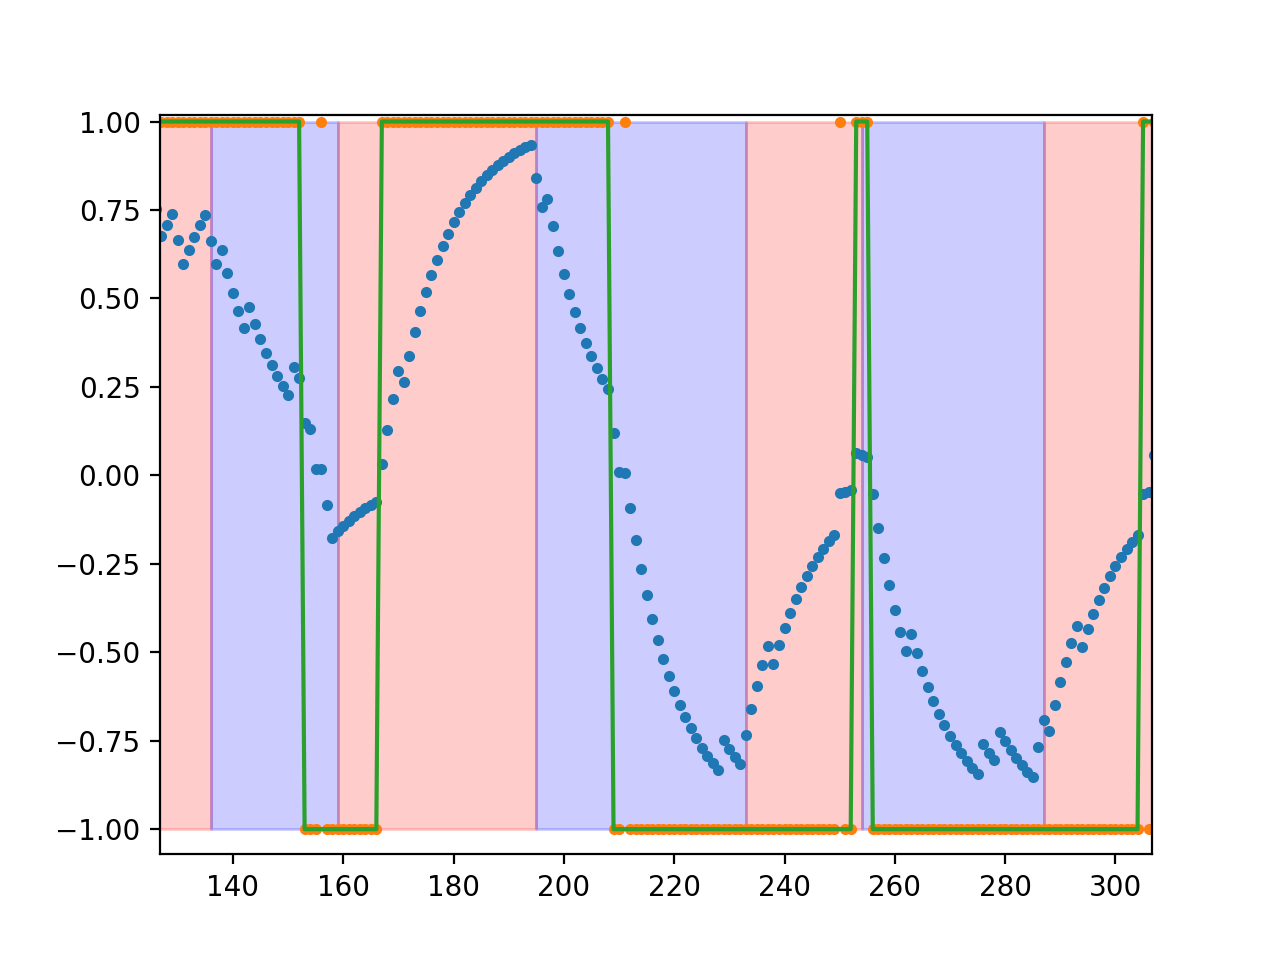

(0.0, 400.0)

In [3]:
plt.figure()
plt.plot(agent.find_prob(), '.')
plt.plot(np.array(agent.choice_history) * 2 - 1, '.')
plt.plot(z_states * 2 - 1)

blockswitches = np.cumsum(world.ntrialblocks)
for i in range(len(world.ntrialblocks) - 1):
    if i % 2:
        plt.fill_between([blockswitches[i], blockswitches[i+1]], [-1,-1], [1, 1], color='r', alpha=0.2)
    else:
        plt.fill_between([blockswitches[i], blockswitches[i+1]], [-1,-1], [1, 1], color='b', alpha=0.2)
        
plt.xlim([0, 400])


<IPython.core.display.Javascript object>


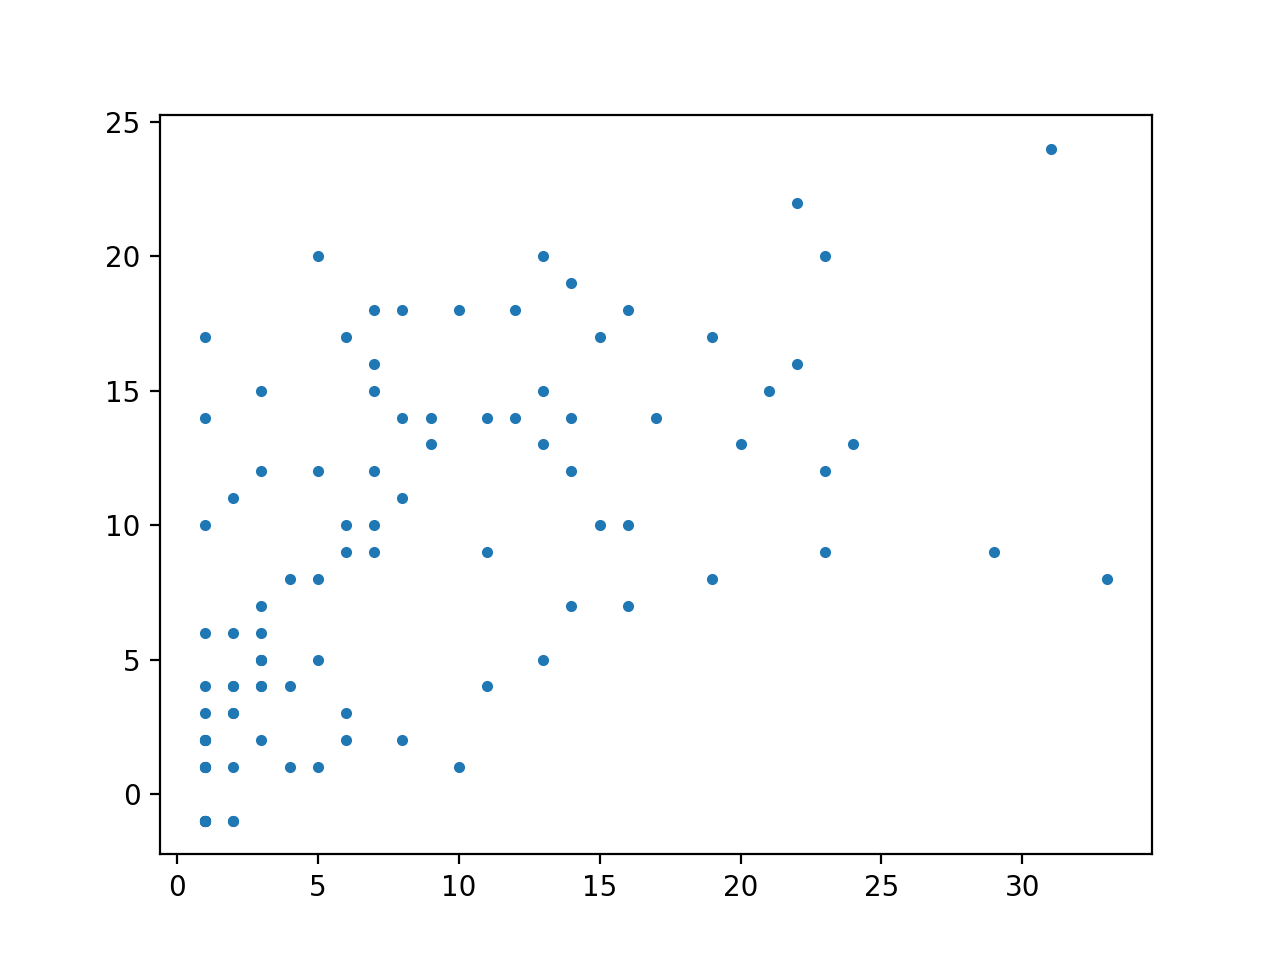

In [24]:
# Correlations based on number of rewards and errors (simple counting)
Nerrors = get_num_errors_leading_block(world, agent)
Nrews = get_num_rewards_trailing_block(world, agent)
# plt.plot(lst)
plt.figure()
plt.plot(Nrews[:-1], Nerrors[1:], '.')

In [30]:
lst

array([ 2., 41., 23., 16., 20., 23., 32., 12., 35., 33., 25., 26., 21.,
       29., 20., 10., 16., 31., 23., 13., 36., 26., 48., 27., 25., 15.,
       23., 14., 20., 18., 31., 24., 17., 27., 22., 24., 33., 26., 27.,
       21., 22., 33., 14., 21., 16., 15., 31., 26., 42., 33., 19., 22.,
       31., 34., 22., 20., 23., 19., 34., 15., 20., 27., 23., 16., 18.,
       18., 17., 16., 13., 28., 38., 23., 28., 27., 15., 24., 29., 24.,
       27., 14., 29., 17., 27., 24., 18., 32., 15., 29., 25., 10., 27.,
       32., 21., 23., 29., 15., 20., 14., 31., 27.])

In [32]:
lst = get_switch_times(world, agent).astype('float')

<IPython.core.display.Javascript object>


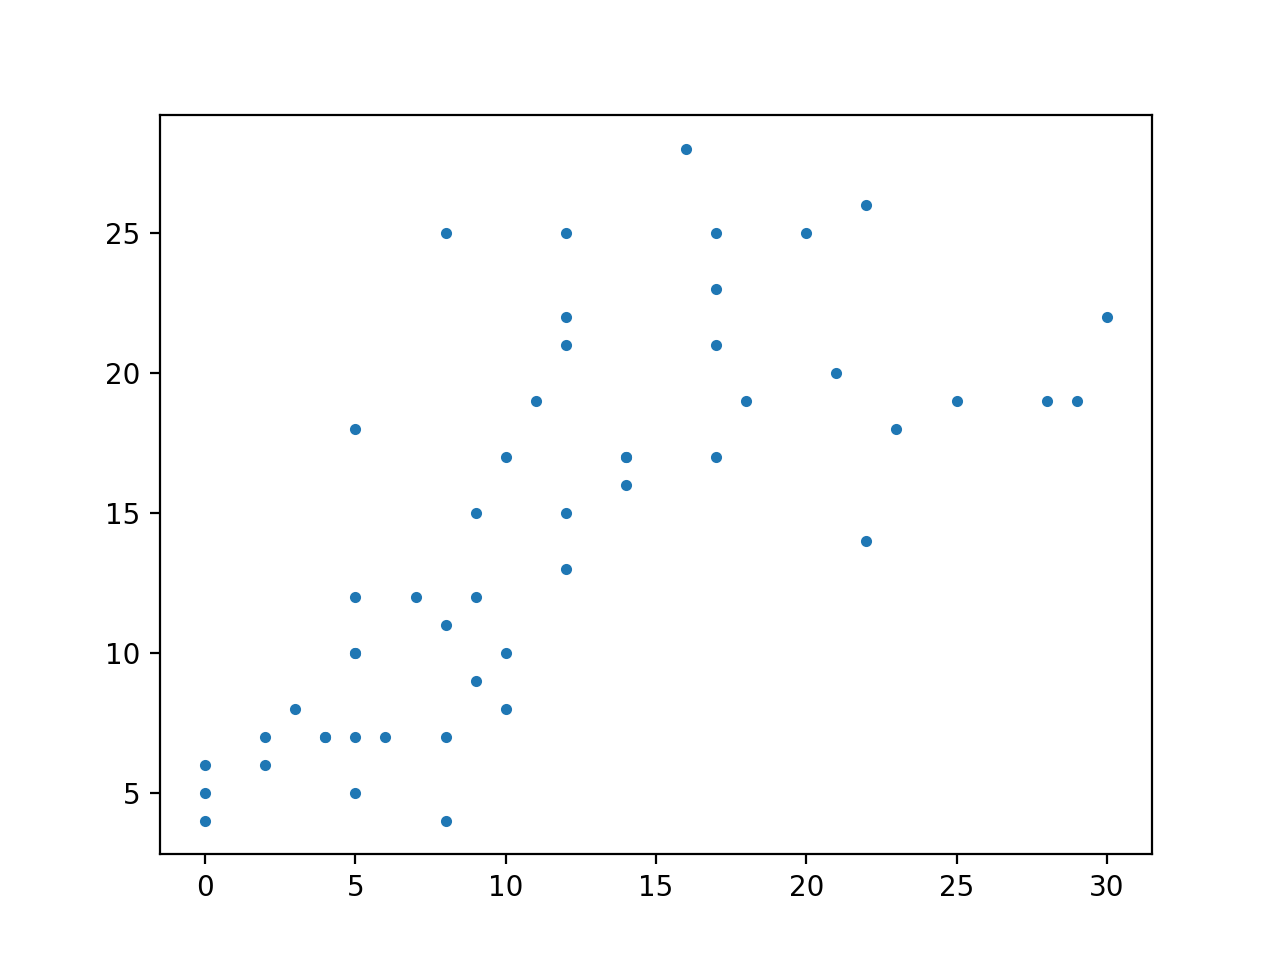

In [37]:
# Correlations based on hidden hmm fitting
lst = get_switch_times(world, agent).astype('float')
lst[lst == -1] = np.nan
nafterswitch = world.ntrialblocks[:-1] - lst
plt.figure()
plt.plot(nafterswitch[:-1], lst[1:], '.')

In [5]:
# Aggregate data
xarr = nafterswitch[:-1]
yarr = lst[1:]
order = np.argsort(xarr)
xsorted = xarr[order]
ysortbyX = yarr[order]

xvals, idx = np.unique(xsorted, return_index=True)
ysplit = np.split(ysortbyX, idx[1:])
# Mean of each split
means = []
stds = []
for elem in ysplit[1:]:
    means.append(np.nanmean(elem))
    stds.append(np.nanstd(elem) / np.sqrt(len(elem)))

<IPython.core.display.Javascript object>


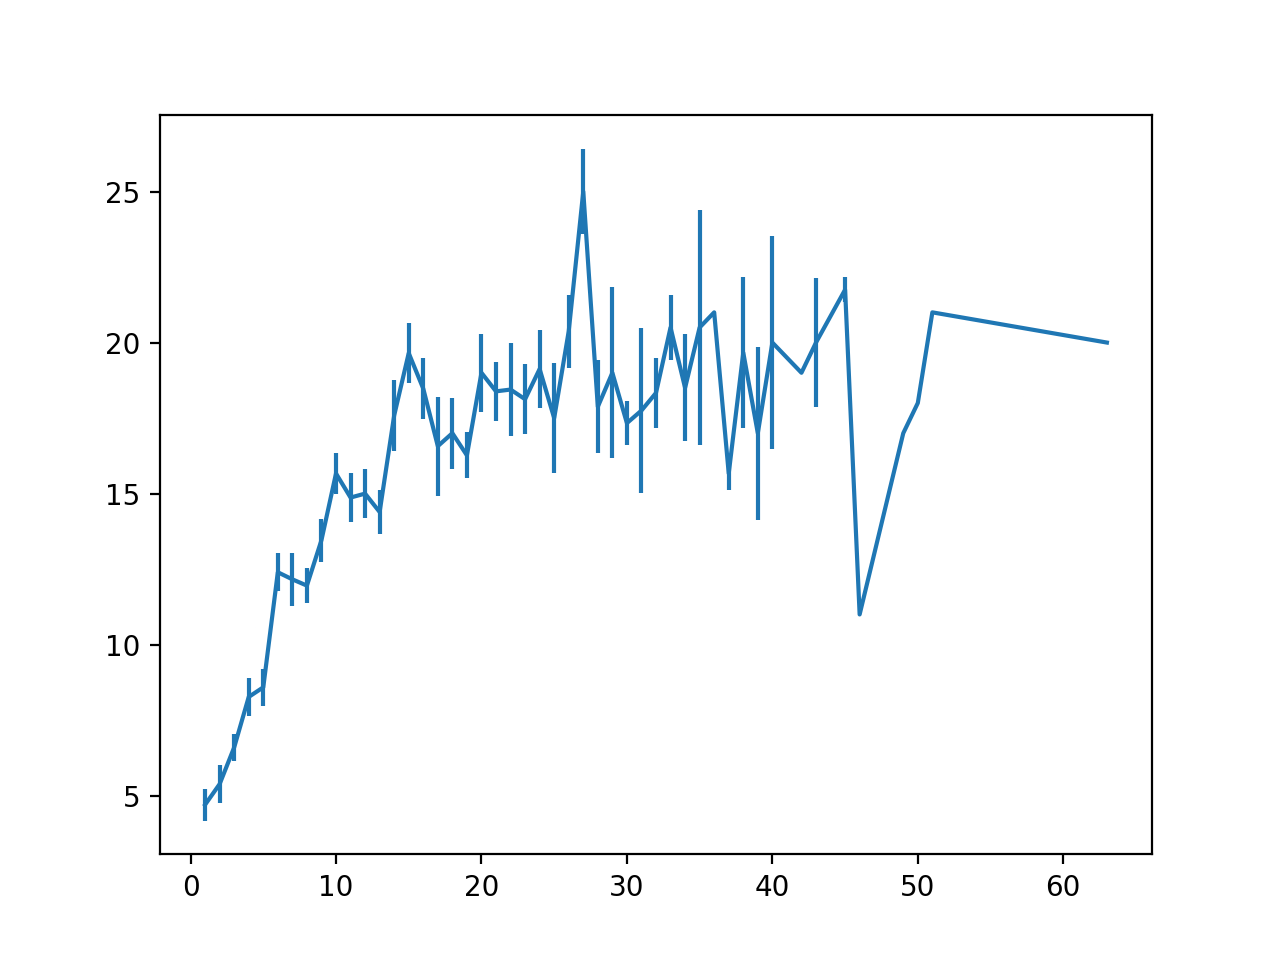

<ErrorbarContainer object of 3 artists>

In [108]:
plt.figure()
plt.errorbar(xvals[1:], means, stds)

<IPython.core.display.Javascript object>


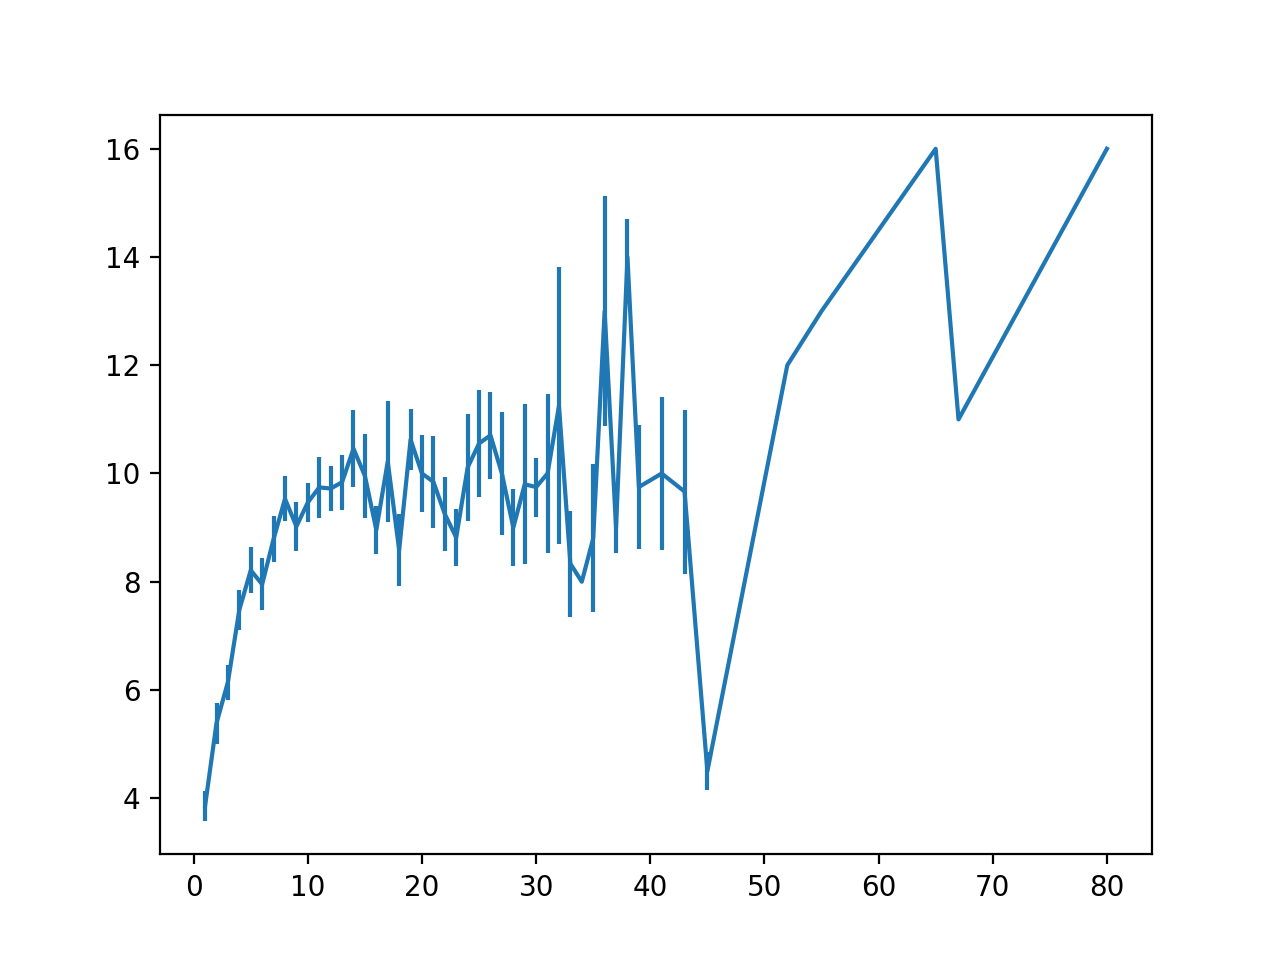

<ErrorbarContainer object of 3 artists>

In [113]:
plt.figure()
plt.errorbar(xvals[1:], means, stds)

In [87]:
a = np.arange(20)
np.split(a, [0,4,8])

[array([], dtype=int64),
 array([0, 1, 2, 3]),
 array([4, 5, 6, 7]),
 array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])]

<IPython.core.display.Javascript object>


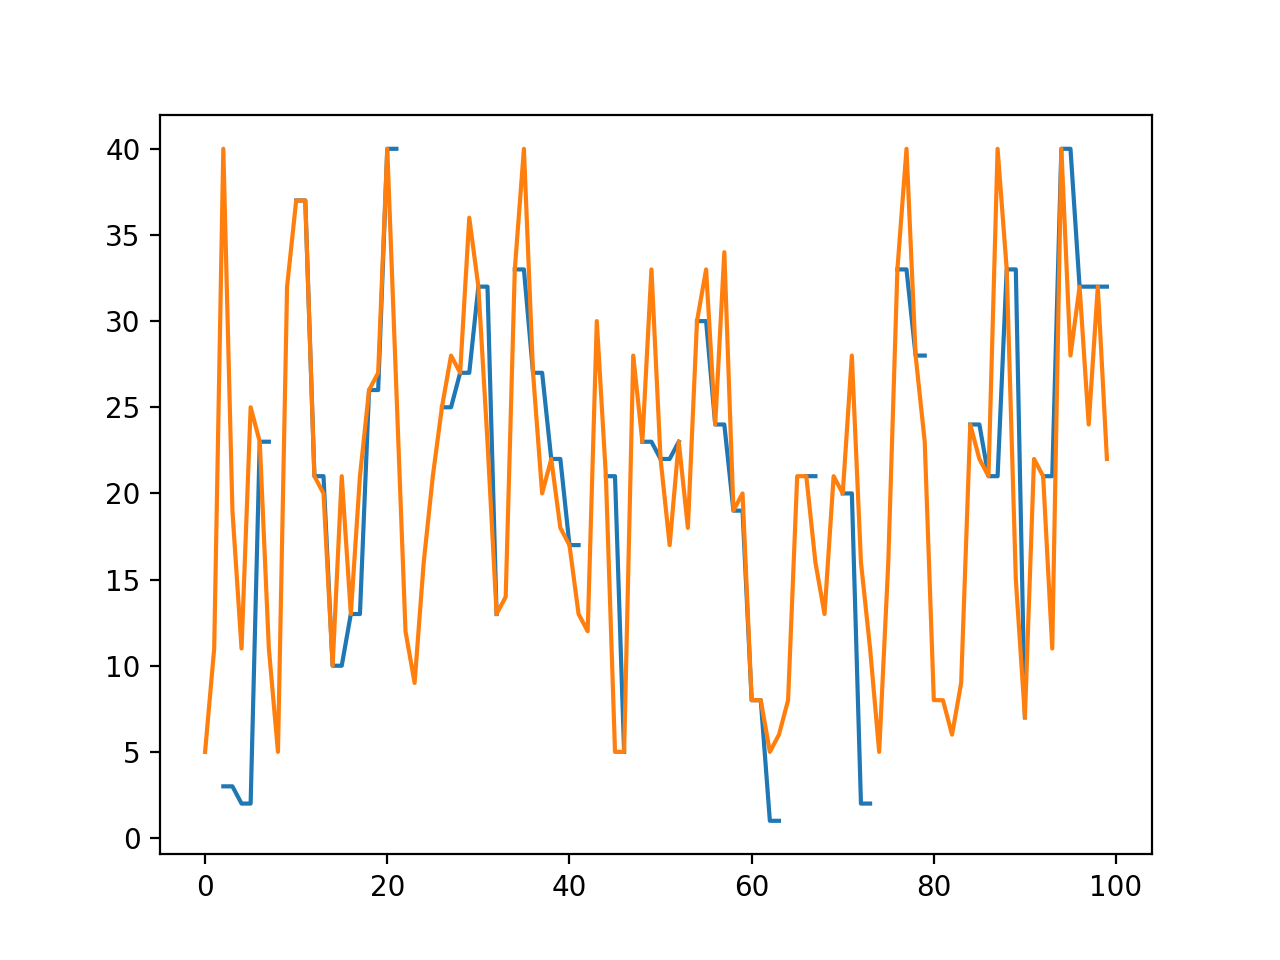

[]

In [7]:
plt.figure()
plt.plot(lst)
plt.plot(world.ntrialblocks[:-1])
plt.plot()

In [12]:
def simulate_rew_error_correlations(world, agent):
#     world = ForagingWorld(prew=0.9, psw=0.1, pstruct=[5, 100], nblockmax=1000)
#     agent = ValueAccumulationAgent(gamma=gamma, beta=10)
    exp = Experiment(agent, world)
    exp.run()  

    choicelst = split_by_trials(agent.choice_history, world.ntrialblocks, chop='none')
    
    lst = get_switch_times(world, agent).astype('float')
    lst[lst == -1] = np.nan
    nafterswitch = world.ntrialblocks[:-1] - lst
    
    # Aggregate data
    xarr = nafterswitch[:-1]
    yarr = lst[1:]
    order = np.argsort(xarr)
    xsorted = xarr[order]
    ysortbyX = yarr[order]

    xvals, idx = np.unique(xsorted, return_index=True)
    ysplit = np.split(ysortbyX, idx[1:])
    
    # Mean of each split
    means = []
    stds = []
    for elem in ysplit[1:]:
        means.append(np.nanmean(elem))
        stds.append(np.nanstd(elem) / np.sqrt(len(elem)))
    
    return xvals[1:], means, stds, ysplit

In [14]:
ysplit

[array([ 3.,  4.,  7.,  1.,  4.,  1.,  2.,  3.,  3.,  4.,  3.,  3.,  4.,
         3.,  6.,  2.,  1.,  3.,  2.,  2.,  3.,  2.,  6.,  3.,  3.,  6.,
         6.,  2.,  5.,  5.,  4.,  4.,  2.,  4.,  4.,  4.,  4.,  6.,  2.,
         5.,  5.,  7.,  5.,  1.,  1.,  3.,  3.,  2.,  5.,  1.,  4.,  4.,
         4., nan,  2.,  1.,  6.,  4.,  6.,  3.]),
 array([ 4.,  7.,  6.,  3.,  8.,  4.,  2.,  4.,  1.,  4.,  2.,  6.,  3.,
         2.,  3.,  4.,  2.,  7.,  5.,  1.,  1.,  6.,  3., 11.,  6.,  3.,
         2.,  2.,  2.,  3.,  8.,  6.,  4.,  4.,  3.,  5., nan,  3.,  5.,
         3.,  7.,  4.,  2.,  9.,  7.,  1.,  5., nan,  2.,  4.,  7.,  6.,
        nan,  3.,  6.,  4.,  5.,  2.,  6.,  2.,  3.,  3.,  3.,  4., 10.,
         5.,  6.,  2.,  7.,  4.]),
 array([ 6.,  2.,  4.,  2.,  6.,  4.,  2.,  3.,  6.,  2.,  4.,  5.,  3.,
         2.,  5.,  3.,  5.,  4.,  3.,  6.,  2.,  7.,  5.,  3.,  4.,  5.,
         7.,  6.,  5.,  8.,  4.,  6.,  5.,  5.,  7.,  9.,  3.,  3.,  4.,
         2.,  8.,  3.,  2.,  5.,  4.,  

In [60]:
EGreedyInferenceBasedAgent?

<IPython.core.display.Javascript object>


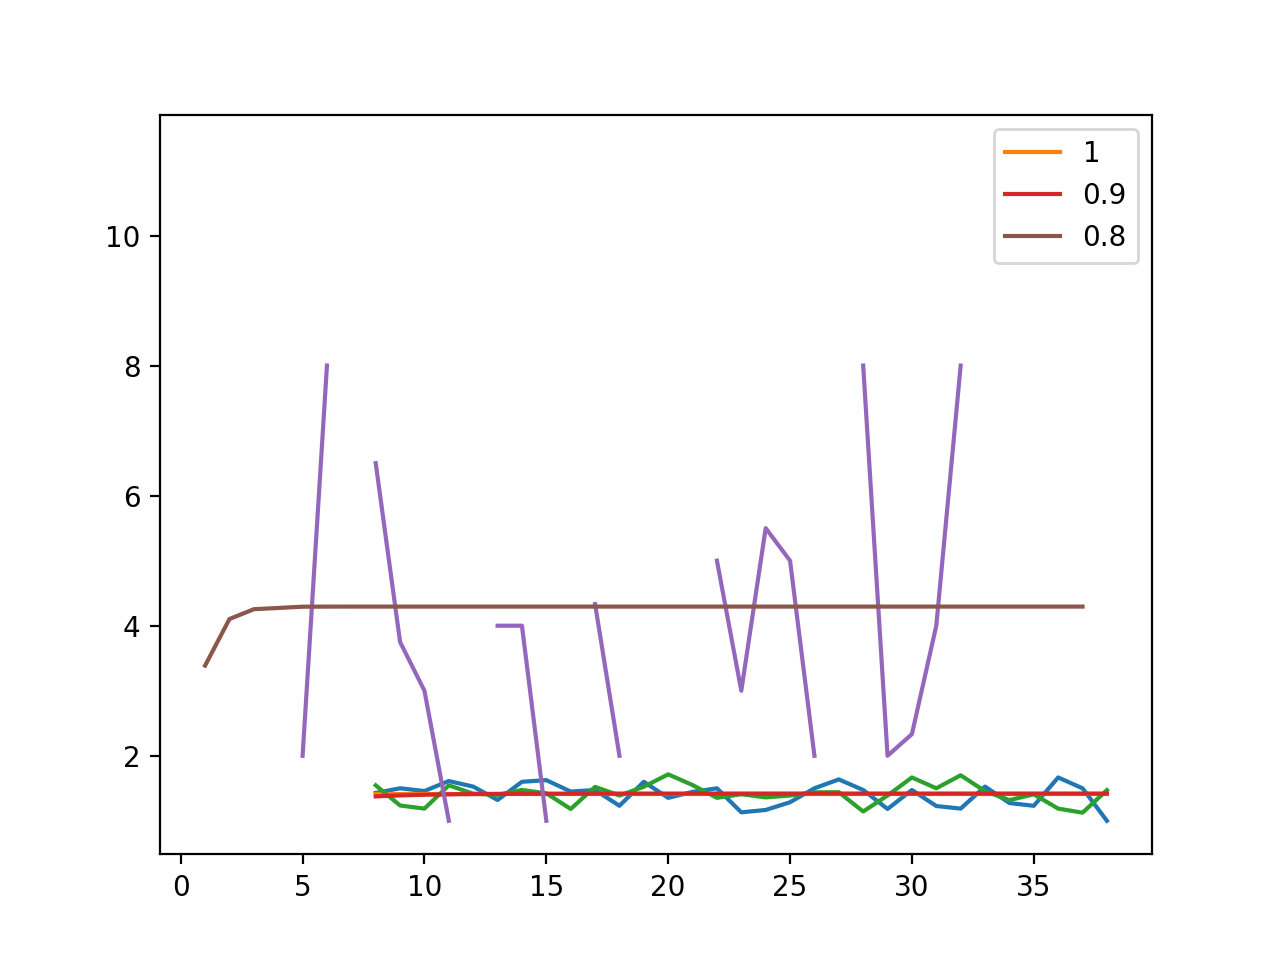

[1.80931891 1.4058318  5.        ]
[0.4354666  1.41872498 5.        ]
[1.55458634 4.29405618 5.        ]


In [66]:
gammalst = np.linspace(0.1, 1, 10)
np.random.seed(124)

rlow = 0.2
rhigh = 0.8
ntrials_per_block = [10, 40]
nblocks = 1000
# world, ntrials = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])

plt.figure()
for prew in [1, 0.9, 0.8]: #, 1.1, 1.2]:
#     world = ForagingWorld(prew=0.9, psw=0.1, pstruct=[5, 100], nblockmax=1000)
    world, ntrials = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
    agent = EGreedyInferenceBasedAgent(prew=prew, pswitch=0.2, eps=0)
#     agent = EGreedyQLearningAgent(gamma=gamma, eps=0.01)
#     agent = ValueAccumulationAgent(gamma=gamma, beta=10)
    xvals, means, stds, ysplit = simulate_rew_error_correlations(world, agent)
    params, ypred = fit_expfun2([0.5, 4, 5], xvals, np.array(means))
    print(params)
    plt.plot(xvals, means)
#     plt.errorbar(xvals, means, stds)
    plt.plot(xvals, ypred, label=str(prew))
    
plt.legend()

In [55]:
~np.isnan(xvals) & ~np.isnan(np.array(means))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False])

In [48]:
yvals = [np.nan, np.nan]

sum(~np.isnan(np.array(yvals)))

0

In [40]:
yvals = np.array(means)
goodidx = ~np.isnan(xvals) & ~np.isnan(yvals)
print(xvals[goodidx])
print(yvals[goodidx])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 27. 28. 29. 30. 31. 33. 34. 35. 36.]
[10.66666667  3.          8.5        15.         15.6        15.66666667
 11.4        10.5        10.5        15.         13.         14.8
  3.          7.         10.         21.5         9.83333333 15.
 21.75       16.         25.66666667  3.66666667 12.         24.25
 17.28571429 24.5        14.         15.5        10.5         1.
 19.         11.66666667 32.         19.6       ]


In [5]:
fit_expfun2([0.5, 4, 5], xvals, np.array(means))

/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
<ipython-input-4-0668049d0f60>:19: RuntimeWarning: overflow encountered in square
  return np.sum((pred - y) ** 2)
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
<ipython-input-4-0668049d0f60>:19: RuntimeWarning: overflow encountered in square
  return np.sum((pred - y) ** 2)


(array([ 0.08465478, 23.03951772,  5.        ]),
 array([ 1.87013076,  3.58846194,  5.16731521,  6.61801205,  7.95095501,
         9.17570223, 10.30103602, 11.33502583, 12.28508609, 13.15802943,
        13.96011545, 14.6970957 , 15.37425484, 15.99644859, 16.56813852,
        17.09342405, 17.57607186, 18.01954287, 18.42701708, 18.80141638,
        19.14542548, 19.46151116, 19.75193999, 20.01879454, 20.26398836,
        20.48927966, 20.69628393, 20.88648555, 21.0612484 , 21.22182564,
        21.36936874, 21.50493569, 21.62949858, 21.74395064, 21.94573842,
                nan]))

In [9]:
exp_fun2(xvals, [ 0.08465478, 23.03951772,  5.])

array([ 1.87013083,  3.58846208,  5.16731539,  6.61801228,  7.95095527,
        9.17570251, 10.30103632, 11.33502615, 12.28508642, 13.15802976,
       13.96011579, 14.69709604, 15.37425518, 15.99644893, 16.56813885,
       17.09342437, 17.57607217, 18.01954317, 18.42701738, 18.80141667,
       19.14542576, 19.46151143, 19.75194025, 20.01879479, 20.2639886 ,
       20.48927989, 20.69628415, 20.88648576, 21.06124859, 21.22182583,
       21.36936892, 21.50493585, 21.62949874, 21.74395079, 21.94573856,
               nan])

In [10]:
xvals

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 36., nan])

In [66]:
sum(world.ntrialblocks)

25069

In [60]:
world.side_history

[array([False, False]),
 array([False,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True, False]),
 array([False, False]),
 array([False,  True]),
 array([False,  True]),
 array([False, False]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True, False]),
 array([ True, False]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([ True, F

In [59]:
get_switch_times(world, agent).astype('float')

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0 False
[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1 False
skipping
[0 0 0 0 0 0 0 1 1 1]
2 False
skipping
[1 1 0 0 0 0 0 0 0 0 0]
3 False
skipping
[0 0 1 1 1 1 1 1 1 1 1 1]
4 False
skipping
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
5 False
skipping
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
6 False
skipping
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7 False
skipping
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
8 False
skipping
[1 1 1 1 1 1 1 1 1 1]
9 False
skipping
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
10 False
[1 1 1 1 1 1 1 0 0 0]
11 False
skipping
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
12 False
skipping
[1 1 1 1 1 1 1 1 1 0 0 0 0 0]
13 False
skipping
[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
14 False
skipping
[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
15 False
skipping
[0 0 0 0 0 0 0 1 1 1 1 1 1 1

[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
446 False
skipping
[1 1 1 0 0 0 0 0 0 0 0 0 0]
447 False
skipping
[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
448 False
skipping
[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
449 False
skipping
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
450 False
skipping
[1 1 1 1 0 0 0 0 0 0 0 0 0 0]
451 False
skipping
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
452 False
skipping
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
453 False
skipping
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
454 False
skipping
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
455 False
skipping
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
456 False
skipping
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
457 False
skipping
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
458 False
skipping
[1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0

823 False
skipping
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
824 False
skipping
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
825 False
skipping
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
826 False
skipping
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
827 False
skipping
[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
828 False
skipping
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
829 False
skipping
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
830 False
skipping
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
831 False
skipping
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
832 False
skipping
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
833 False
skipping
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
834 False
skipping
[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
835 False
skipping
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1]
836 False
skipping
[1 1 1 1 1 1 1 1 1 

array([34., -1., -1., -1., -1., -1., -1., -1., -1., -1., 15., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1., -1., 14., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., 31., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  3., -1., -1., -1., -1

<IPython.core.display.Javascript object>


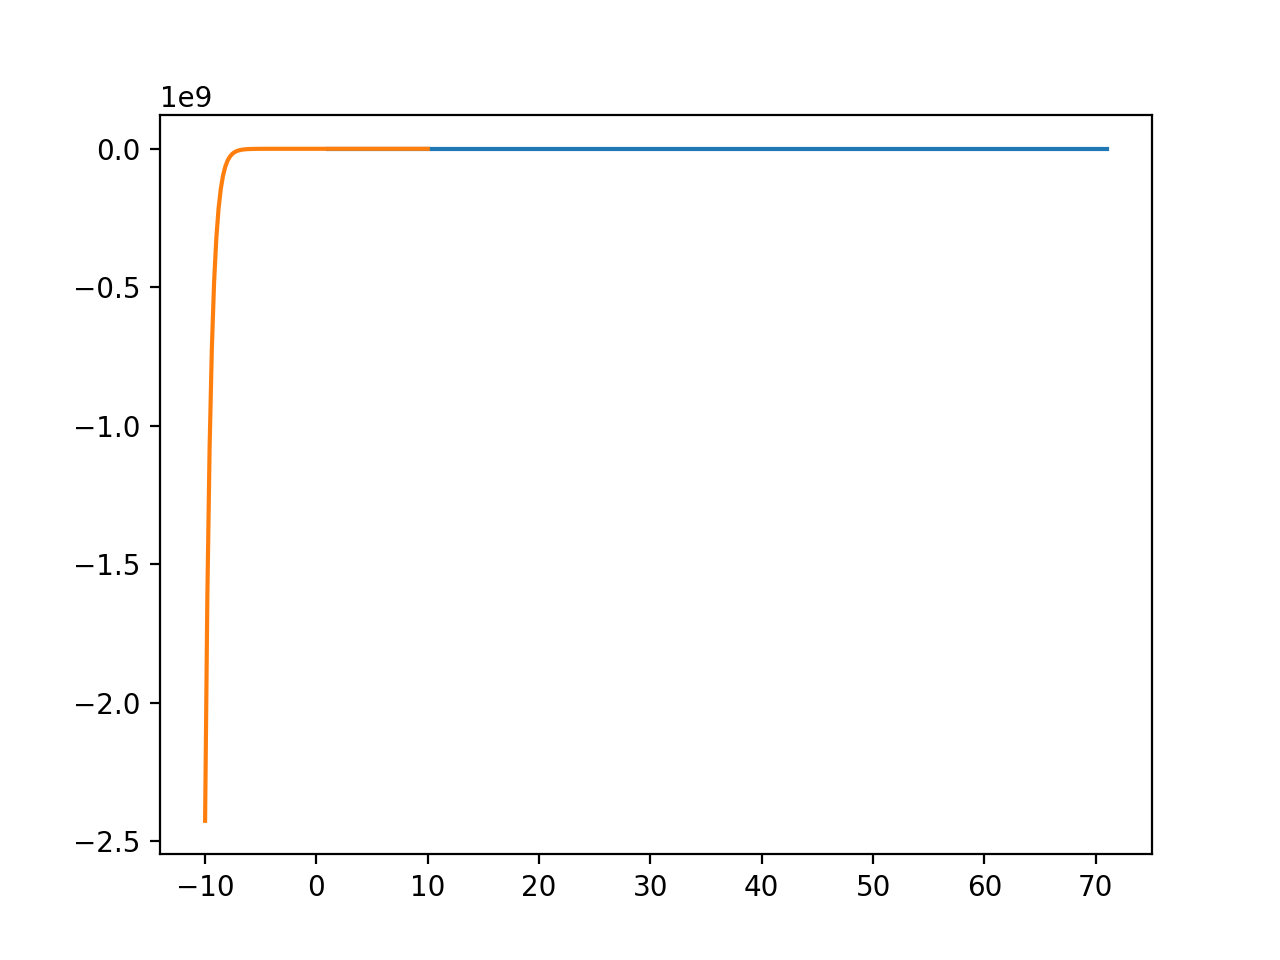

In [16]:
plt.figure()
plt.plot(xvals,means)

In [56]:
# Let's try to fit an exponential function to these data points
def exp_fun(x, params):
    alpha = params[0]
    beta = params[1]
    C = params[2]
    return C - beta * np.exp(-alpha * x)

def exp_fun2(x, params):
    alpha = params[0]
    C = params[1]
    return C - C * np.exp(-alpha * x)

def loss(params, x, y):
    pred = exp_fun(x, params)
    return np.sum((pred - y) ** 2)

def loss2(params, x, y):
    pred = exp_fun2(x, params)
#     print('params = ', params)
#     print('pred =', pred)
    return np.sum((pred - y) ** 2)

def fit_expfun2(params0, datax, datay):
    # Filter out nan's in datax and datay
    goodidx = ~np.isnan(datax) & ~np.isnan(datay)

    goody = datay[goodidx]
    goodx = datax[goodidx]
    
    result = scipy.optimize.minimize(loss2, params0, (goodx, goody), bounds=((0, None), (0, None), (None, None)))
    params = result.x
    ypred = exp_fun2(datax, params)
    return params, ypred

def fit_expfun(params0, datax, datay):
    # Filter out nan's in datax and datay
    goody = datay[~np.isnan(datax)]
    goodx = datax[~np.isnan(datax)]
    
    result = scipy.optimize.minimize(loss, params0, (goodx, goody))
    params = result.x
    ypred = exp_fun(datax, params)
    return params, ypred



In [18]:
scipy.optimize.minimize?

In [19]:
x= np.linspace(-2, 5, 100)
params0 = [1, 5, 10]
y = exp_fun(x, params0)
ynoise = y + np.random.randn(len(y)) * 1

params, ypred = fit_expfun([0.5, 4, 5], xvals, np.array(means))
print(params)

# print(loss(x, ynoise, 1, 5, 10))
plt.figure()
# plt.plot(x, y)
plt.plot(xvals, means, '.')
plt.plot(xvals, ypred)

TypeError: fit_expfun() got an unexpected keyword argument 'bounds'

In [69]:
params

array([0.5, 4. , 5. ])

[0.5 4.  1. ]


<IPython.core.display.Javascript object>


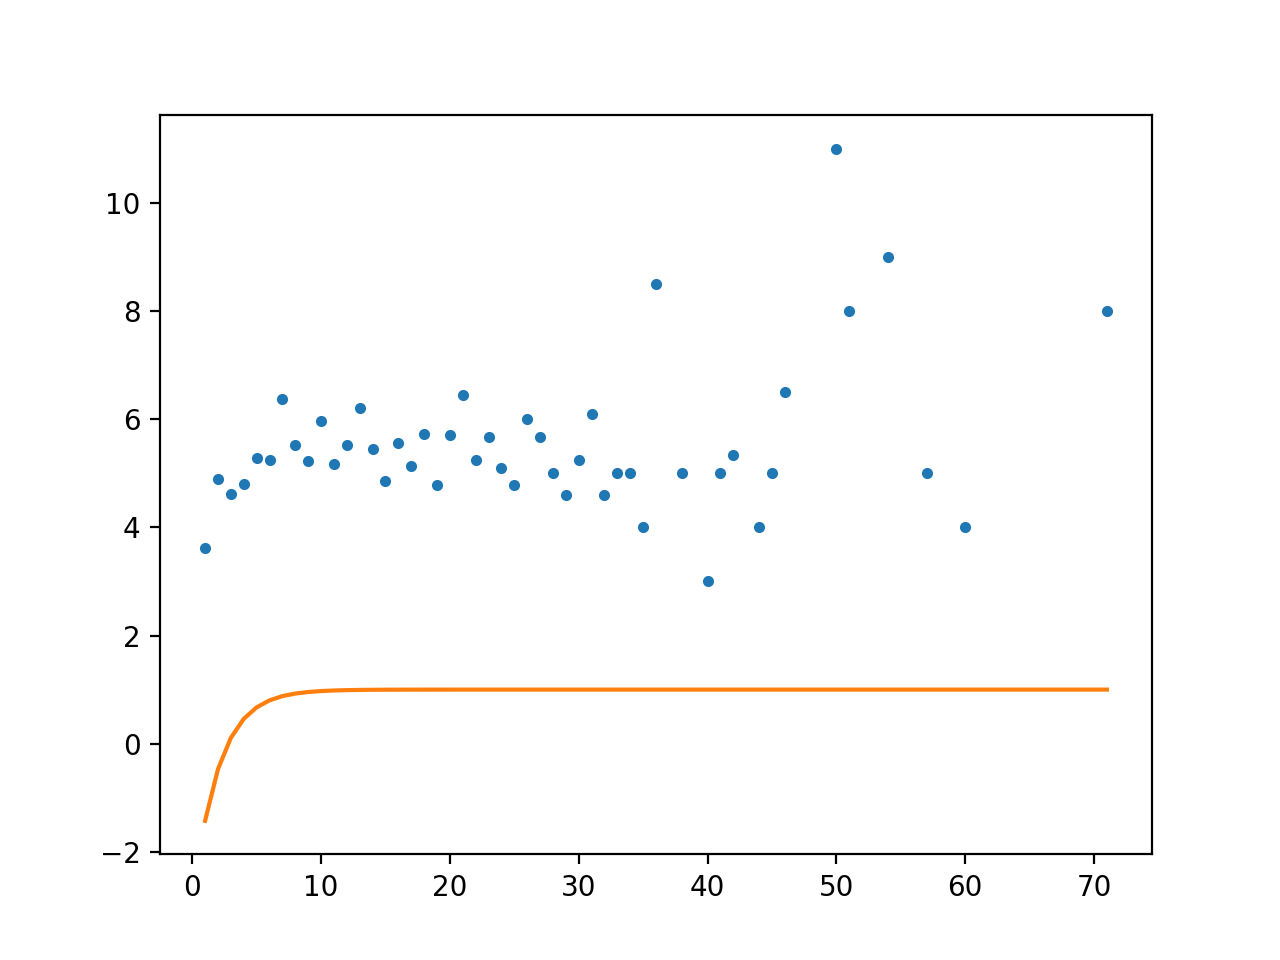

In [72]:
params, ypred = fit_expfun([0.5, 4, 1], xvals, means)
print(params)
# print(loss(x, ynoise, 1, 5, 10))
plt.figure()
# plt.plot(x, y)
plt.plot(xvals, means, '.')
plt.plot(xvals, ypred)

In [93]:
datax = xvals
datay = np.array(means)
goody = datay[~np.isnan(datax)]
goodx = datax[~np.isnan(datax)]

result = scipy.optimize.minimize(loss, params0, (datax, datay))